# Lab 2

In [1]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from random import randrange as rand

im_lena = np.array(Image.open("Images_TP/Lena.jpg"))
im_noisy_lena = np.array(Image.open("Images_TP/noisy_Lena.png"))
im_noise = np.array(Image.open("Images_TP/noise.tif"))
im_clown = np.array(Image.open("Images_TP/clown.tif"))

# Image.fromarray(im_dungeon).show()
def show(im,im_ref=im_lena,cmap= 'viridis',cmap_ref='viridis'):
    f, axarr = plt.subplots(1,2)    #subplot(r,c) -> r:nb_rows, c:nb_columns
    axarr[0].set_title('After')
    axarr[0].imshow(im,cmap=cmap)
    axarr[1].set_title('Before')
    axarr[1].imshow(im_ref,cmap=cmap_ref)


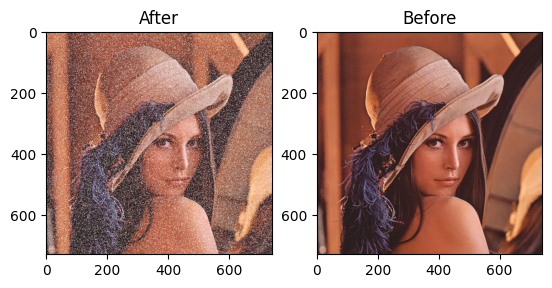

In [49]:
def add_noise(im,size=1,ratio=1/6):
    #ratio : nb de pixels bruités par pixels de l'image
    img = im[:,:,(0,1,2)]
    nb_alea = int((im.shape[0] * im.shape[1])*(ratio/size**2))
    for _ in range(0,nb_alea):
        x = rand(0,im.shape[0])
        y = rand(0,im.shape[1])
        noise = [[[255]*3]*size]*size
        if img[x:x+size,y:y+size].shape == (size,size,3):
            img[x:x+size,y:y+size] = noise
    return img

im_noisy_lena2 = add_noise(im_lena,1)
show(im_noisy_lena2)

## 1.  Le filtre médian, un filtre non-linéaire

La technique de filtre médian est largement utilisée en 
traitement d'images numériques, car elle permet de réduire le bruit tout en conservant les contours de 
l'image. L'idée principale du filtre médian est de remplacer chaque pixel par la valeur médiane de son 
voisinage.\
Le filtre médian va d'abord trier ces valeurs par ordre croissant, et prendre la valeur médiane.

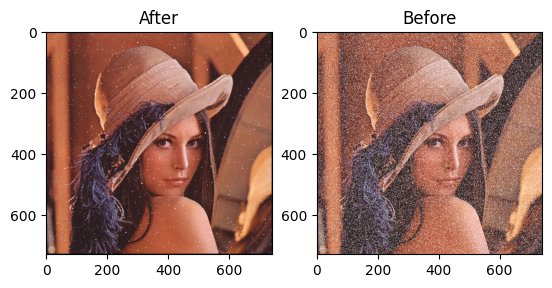

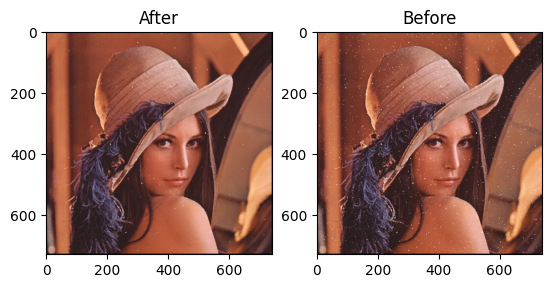

In [50]:
def median_filter_RGB(im,size_filtre):
    #size_filtre : nb de pixels sur un côté
    height, width, nb_channels = im.shape
    assert(nb_channels < 4)        #besoin image RGB
    assert(size_filtre%2 == 1)      #filtre de taille impaire
    bord = size_filtre//2
    img = np.zeros_like(im)
    for y in range(bord,height-bord):
        for x in range(bord,width-bord):
            for c in range(0,nb_channels):
                input = im[y-bord:y+bord+1,x-bord:x+bord+1,c]
                img[y,x,c] = np.median(input,axis=None)
    return img

im_temp = median_filter_RGB(im_noisy_lena2,3)
show(im_temp,im_noisy_lena2)
im_temp2 = median_filter_RGB(im_temp,3)
show(im_temp2,im_temp)

## 2. Filtrage bruit périodique

np.fft.fft2
shift
log(abs)

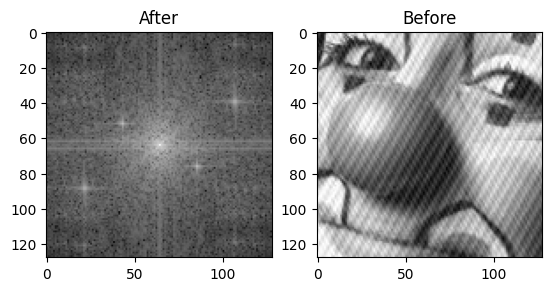

In [2]:
def specral_image(im):
    img = np.array(im[:,:])   #convertit RGBa/RGB en RGB et copie
    img = np.fft.fft2(img)
    return np.fft.fftshift(img)

im_temp = specral_image(im_clown)
show(np.log(np.abs(im_temp)),im_clown,cmap='grey',cmap_ref='grey')